In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Copy data

In [2]:
# os.chdir('/content')

In [2]:
BASE_PATH_DATA = '/content/drive/MyDrive/ai/ycup21/data/'

In [3]:
!ls {BASE_PATH_DATA}

id_to_remove.npy     metadata.json	  ycup21-images-1.tgz
index_to_remove.npy  ycup21-datasets.tgz  ycup21-images-2.tgz


In [4]:
%%time
file_name = 'ycup21-images-2.tgz'
file_path = BASE_PATH_DATA + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xf {local_path}

CPU times: user 336 ms, sys: 66.4 ms, total: 402 ms
Wall time: 1min 6s


# Install libs

In [5]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 79.7 MB/s 
     |████████████████████████████████| 56 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 73.2 MB/s 
     |████████████████████████████████| 596 kB 90.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!pip install pytorch-lightning
# !pip install jsonlines
!pip install hydra-core --upgrade
!pip install bpemb
!pip install segmentation_models_pytorch

     |████████████████████████████████| 925 kB 4.1 MB/s 
     |████████████████████████████████| 829 kB 81.1 MB/s 
     |████████████████████████████████| 282 kB 79.4 MB/s 
     |████████████████████████████████| 125 kB 81.6 MB/s 
     |████████████████████████████████| 1.3 MB 60.7 MB/s 
     |████████████████████████████████| 271 kB 81.0 MB/s 
     |████████████████████████████████| 160 kB 72.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4cabd43dfad4b552df337cd16e1a511dcd35d6ab71ded07f8af1e7c2879d8f5a
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
     |████████████████████████████████| 145 kB 4.2 MB/s 
     |████████████████████████████████| 74 kB 4.6 MB/s 
     |████████████████████████████████| 11

     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 87 kB 3.4 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 376 kB 23.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d513373bf9261f570ca4aa27344d252432d518100ecabc7bfac964d81a581756
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ca35aed4889ccac1d316d676f448b43efcee62d233f63e20f5aac7f301568a1d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Imports

In [85]:
import os

In [88]:
# BASE_PATH = '/content/drive/MyDrive/ai/ycup21/main/'
BASE_PATH = '/Users/michaelka/Developer/ml/projects/ycup21/main/'

In [89]:
os.chdir(BASE_PATH)

In [90]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [91]:
!pwd

/Users/michaelka/Developer/ml/projects/ycup21/main


In [92]:
import numpy as np

from hydra import initialize, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from dataset import I2TDataset, prepare_metadata, get_train_val

In [93]:
import matplotlib.pyplot as plt

In [94]:
abs_config_dir=os.path.abspath("config")
with initialize_config_dir(config_dir=abs_config_dir):
# with initialize(config_path="config"):
    cfg = compose(
        config_name='base',
        overrides=[
            "path=local", # colab, local
            "mode=debug",
            "+experiment=bert",
        ]
    )
    print(OmegaConf.to_yaml(cfg))

train:
  batch_size_train: ${mode.batch_size_train}
  batch_size_val: ${mode.batch_size_val}
  monitor: val/nce
  trainer_params:
    gpus: 0
    deterministic: true
    num_sanity_val_steps: 0
    checkpoint_callback: false
    max_epochs: ${mode.max_epochs}
    log_every_n_steps: ${mode.log_every_n_steps}
  checkpoint_callback:
    _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: ${train.monitor}
    mode: min
data:
  dataloader_workers: ${path.dataloader_workers}
  collate_fn: false
  split_ratio: 0.9
  metadata:
    metadata_directory: ${path.metadata_directory}
    images_directory: ${path.images_directory}
    dataset_size: ${mode.dataset_size}
  train:
    images_directory: ${path.images_directory}
    randomize: true
  val:
    images_directory: ${path.images_directory}
    randomize: false
tokenizer:
  _target_: dataset.BERTTokenizer
  model_name: ${model.text.encoder.model_name}
  max_length: 10
model:
  image:
    _target_: ${model.modality_encoder}
    out

In [95]:
metadata = prepare_metadata(**cfg.data.metadata)

100%|██████████| 20/20 [00:00<00:00, 5427.41it/s]


In [96]:
len(metadata)

19

In [122]:
tokenizer = instantiate(cfg.tokenizer)

In [131]:
dataset = I2TDataset(
    metadata,
    tokenizer,
    cfg.data.metadata.images_directory,
    randomize = False
)
len(dataset)

19

In [ ]:
train_dataset, val_dataset = get_train_val(metadata, tokenizer, cfg)
len(train_dataset), len(val_dataset)

(17, 2)

## Single item

In [32]:
dataset_item = dataset[0]

In [33]:
dataset.data[0]

(1,
 ['samsing a52',
  'samsung a32',
  'смартфон samsung galaxy a32 128gb awesome violet',
  'samsung a 52',
  'samsung galaxy a32 лаванда'])

In [34]:
dataset_item['text']

['samsing a52',
 'samsung a32',
 'смартфон samsung galaxy a32 128gb awesome violet',
 'samsung a 52',
 'samsung galaxy a32 лаванда']

In [35]:
image = dataset_item['image']
image.shape

torch.Size([3, 512, 384])

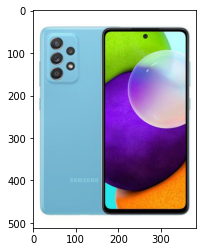

In [36]:
plt.imshow(image.permute(1,2,0))

## Show dataset

In [41]:
def show_dataset(dataset, start_index, count, random=False):
    
    if random:   
        indices = np.random.choice(np.arange(len(dataset)), count, replace=False)
    else:
        indices = np.arange(start_index, start_index+count)

    print(indices)

    size = 5
    rows = 1
    plt.figure(figsize=(count*size,size))
    
    for i, index in enumerate(indices):    

        dataset_item = dataset[index]
        
        image = dataset_item['image']
        text = dataset_item['text']

        plt.subplot(rows,count,i+1)
        plt.grid(False)
        plt.axis('off')
        plt.title(f'Index: {index}\nShape: {list(image.shape)}', fontsize=16)
        plt.imshow(image.permute(1,2,0))

        # plt.text(4, 1, text, ha='left', wrap=True)

[  240 10080 72166 34558 19619]


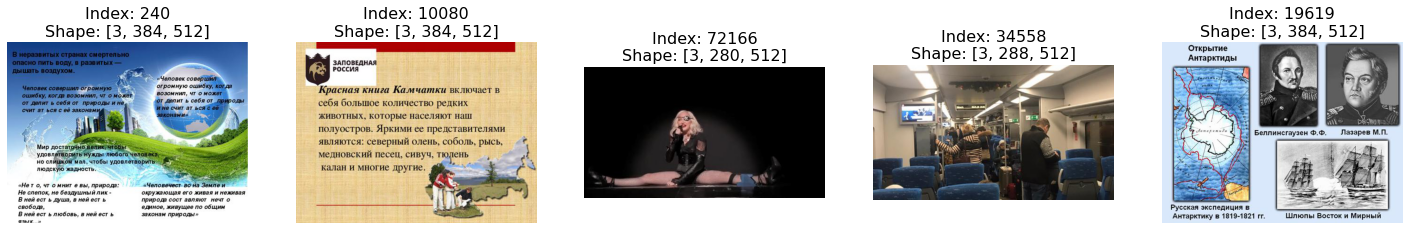

In [66]:
show_dataset(dataset, 0, 5, random=True)

In [51]:
def show_dataset_item(dataset, index):
    
    size = 5
    plt.figure(figsize=(size,size))
    
    dataset_item = dataset[index]
        
    image = dataset_item['image']
    text = dataset_item['text']

    for t in text:
        print(t)

    plt.grid(False)
    plt.axis('off')
    plt.title(f'Shape: {list(image.shape)}', fontsize=16)
    plt.imshow(image.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


268
104762
268
104762
8398
62869


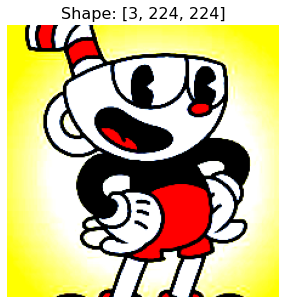

In [87]:
show_dataset_item(dataset, 14133)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_dataset_item(dataset, x)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=19), Output()), _dom_classes=('widget-…

<function __main__.handle_change(x)>

In [ ]:
images = os.listdir(cfg.path.images_directory)
id_to_remove = np.load(os.path.join(cfg.path.metadata_directory, 'id_to_remove.npy'))
index_to_remove = np.load(os.path.join(cfg.path.metadata_directory, 'index_to_remove.npy'))
len(images), len(index_to_remove), len(id_to_remove), len(images) + len(index_to_remove)

(24627, 1990, 1990, 26617)

# DataLoader

In [99]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader

In [100]:
cfg.data.collate_fn

False

In [132]:
if cfg.data.collate_fn:
    collate_fn = train_dataset.collate_fn
else:
    collate_fn = None
        
train_dataloader = DataLoader(
    dataset,
    batch_size=cfg.train.batch_size_train,
    collate_fn=collate_fn,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

In [133]:
dataloader_iter = iter(train_dataloader)

In [134]:
sample_batch = next(dataloader_iter)

In [112]:
# sample_batch

In [113]:
# sample_batch['input_ids'].shape

In [114]:
image_batch = sample_batch['image']
image_batch.shape

torch.Size([4, 3, 224, 224])

In [115]:
text_batch = sample_batch['text']

In [116]:
text_batch

{'input_ids': tensor([[  101, 30476,   404,  3108,  1072,   102,     0,     0,     0,     0],
         [  101, 12427, 38482, 65157,  1441,  1569,   102,     0,     0,     0],
         [  101, 11457, 47852,  2889, 39512,   894, 45930, 90310,   814,   102],
         [  101, 21018, 12556,  8108,   275, 17574,   257,  3699,  1545,   102]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

# EmbeddingBag

In [ ]:
import torch
from torch import nn

In [ ]:
embedding_bag = nn.EmbeddingBag.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [ ]:
x = embedding_bag(text_batch['ids'], text_batch['offsets'])

In [ ]:
x.shape

torch.Size([4, 200])

In [ ]:
embedding = nn.Embedding.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [ ]:
x = embedding(text_batch['ids'])

In [ ]:
x.shape

torch.Size([20, 200])

# Transformers

In [ ]:
import transformers

In [ ]:
MODEL_PATH = 'DeepPavlov/distilrubert-tiny-cased-conversational' # xlm-roberta-base 'distilbert-base-uncased'

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_PATH)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/538 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='DeepPavlov/distilrubert-tiny-cased-conversational', vocab_size=100792, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
metadata[5][1]

['скачать картинки доброе утро мужчине с кофе',
 'доброе утро кофе картинки мужчине',
 'доброе утро шлю тебе кофе для мужчины',
 'кофе для мужчины с добрым утром',
 'твой кофе картинки']

In [ ]:
text = metadata[5][1][0]
text

'скачать картинки доброе утро мужчине с кофе'

In [ ]:
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)
print(len(tokenized_text))

['скачать', 'картинки', 'доброе', 'утро', 'мужчине', 'с', 'кофе']
7


In [ ]:
tokenizer.vocab_size

100792

In [ ]:
MAX_LEN = 10

In [ ]:
encoded_input = tokenizer(
    text,
#     return_tensors='pt',
#     pad_to_max_length=True,
    truncation='longest_first',
    padding='max_length',
    max_length=MAX_LEN
)
encoded_input

{'input_ids': [0, 170481, 198491, 8190, 103, 118123, 75429, 103, 135, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
inputs = tokenizer.encode_plus(
    text,
#     add_special_tokens=True,
#     return_attention_masks=False,
    pad_to_max_length=True,
    max_length=MAX_LEN)

In [ ]:
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [ ]:
model = transformers.AutoModel.from_pretrained(MODEL_PATH)

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# model

In [ ]:
# MultiHeadSelfAttention

In [ ]:
input_ids_tensor = torch.tensor([input_ids])
attention_mask_tensor = torch.tensor([attention_mask])

outputs = model(
    input_ids=input_ids_tensor,
    attention_mask=attention_mask_tensor
)

In [ ]:
outputs.last_hidden_state.shape

torch.Size([1, 10, 768])

In [ ]:
# eff-net-b0 + distilbert-base-uncased
# ViT

In [ ]:
def get_num_of_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
get_num_of_params(model)

66362880

In [ ]:
# hot to know precision?
model.half() # NO

# I2T

In [117]:
import torch
from system import I2T

In [130]:
abs_config_dir=os.path.abspath("config")
with initialize_config_dir(config_dir=abs_config_dir):
# with initialize(config_path="config"):
    cfg = compose(
        config_name='base',
        overrides=[
            "path=local", # colab, local
            "mode=debug",
            # "model=vae_trick",
#             "+experiment=bert",
        ]
    )
    print(OmegaConf.to_yaml(cfg))

train:
  batch_size_train: ${mode.batch_size_train}
  batch_size_val: ${mode.batch_size_val}
  monitor: val/nce
  trainer_params:
    gpus: 0
    deterministic: true
    num_sanity_val_steps: 0
    checkpoint_callback: false
    max_epochs: ${mode.max_epochs}
    log_every_n_steps: ${mode.log_every_n_steps}
  checkpoint_callback:
    _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: ${train.monitor}
    mode: min
data:
  dataloader_workers: ${path.dataloader_workers}
  collate_fn: true
  split_ratio: 0.9
  metadata:
    metadata_directory: ${path.metadata_directory}
    images_directory: ${path.images_directory}
    dataset_size: ${mode.dataset_size}
  train:
    images_directory: ${path.images_directory}
    randomize: true
  val:
    images_directory: ${path.images_directory}
    randomize: false
tokenizer:
  _target_: dataset.BPEmbTokenizer
  model_file: null
  emb_file: null
  segmentation_only: false
  lang: ru
  dim: 200
  vs: 200000
model:
  image:
    _target_:

In [120]:
model_i2t = I2T(config=cfg)

## Filter out dataset

In [34]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader

In [21]:
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('[device] There are %d GPU(s) available.' % torch.cuda.device_count())
        print('[device] We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('[device] No GPU available, using the CPU instead.')

    return device

In [22]:
device = get_device()

[device] There are 1 GPU(s) available.
[device] We will use the GPU: Tesla P100-PCIE-16GB


In [23]:
output_path = '/content/drive/MyDrive/ai/ycup21/main/outputs/2021-10-12/16-39-36/'

In [24]:
checkpoints_path = output_path + 'lightning_logs/version_0/checkpoints/'

In [25]:
checkpoints = os.listdir(checkpoints_path)
checkpoints

['epoch=3-step=8479.ckpt']

In [26]:
checkpoint_path = checkpoints_path + checkpoints[0]

In [27]:
ckpt = torch.load(checkpoint_path, map_location='cpu')

In [28]:
model_i2t.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [29]:
model_i2t = model_i2t.eval()

In [30]:
model_i2t = model_i2t.to(device)

In [31]:
cfg.data.collate_fn

False

In [35]:
if cfg.data.collate_fn:
    collate_fn = train_dataset.collate_fn
else:
    collate_fn = None
        
dataloader = DataLoader(
    dataset,
    batch_size=cfg.train.batch_size_train,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

In [36]:
cfg.train.batch_size_train

32

In [37]:
len(dataloader)

2355

In [38]:
from tqdm import tqdm

In [47]:
images = []
distances = []

for index, data_dict in tqdm(enumerate(dataloader)):
    # if index == 1:
    #     break

    image_name_batch = data_dict["image_name"]
    image_batch = data_dict["image"]
    text_batch = data_dict["text"]

    data_dict["image"] = image_batch.to(device)

    text_batch['input_ids'] = text_batch['input_ids'].to(device)
    text_batch['attention_mask'] = text_batch['attention_mask'].to(device)
    data_dict["text"] = text_batch

    distance = model_i2t.training_step(data_dict, index)

    images.append(image_name_batch)
    distances.append(distance.cpu().detach().numpy())
    
    # print(image_name_batch)
    # print(image_batch.shape)
    # print(text_batch)

2355it [09:57,  3.94it/s]


In [48]:
import pandas as pd

In [49]:
data_frame = pd.DataFrame()
data_frame['image'] = np.concatenate(images)
data_frame['distance'] = np.concatenate(distances)

In [50]:
len(data_frame)

75360

In [51]:
data_frame.head()

,image,distance
0,image_1.jpg,0.577830
1,image_2.jpg,0.594831
2,image_3.jpg,0.638100
3,image_4.jpg,0.602512
4,image_5.jpg,0.607116


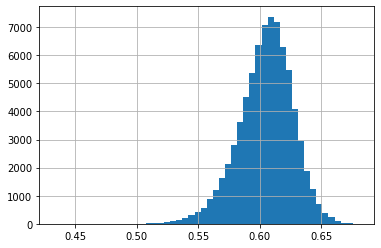

In [53]:
data_frame['distance'].hist(bins=50)

In [55]:
from PIL import Image

In [83]:
def show_images(images, start_index, count, random=False):
    
    if random:   
        indices = np.random.choice(np.arange(len(images)), count, replace=False)
    else:
        indices = np.arange(start_index, start_index+count)

    print(indices)

    size = 5
    rows = 1
    plt.figure(figsize=(count*size,size))
    
    for i, index in enumerate(indices):    

        image_name = images[index]

        img = Image.open(cfg.data.metadata.images_directory + '/' + image_name)
        img = img.convert('RGB')

        plt.subplot(rows,count,i+1)
        plt.grid(False)
        plt.axis('off')
        plt.title(f'Name: {image_name}', fontsize=16)
        plt.imshow(img)

        # plt.text(4, 1, text, ha='left', wrap=True)

In [88]:
images = data_frame[data_frame['distance'] < 0.55]['image']
len(images)

1103

[251 297 855 387 725]


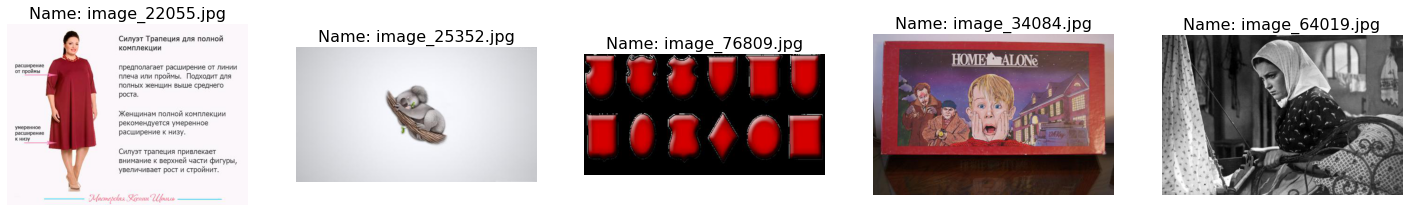

In [96]:
show_images(images.values, 0, 5, random=True)

In [79]:
images = data_frame[data_frame['distance'] > 0.65]['image']
len(images)

887

[364 570 827 325 796]


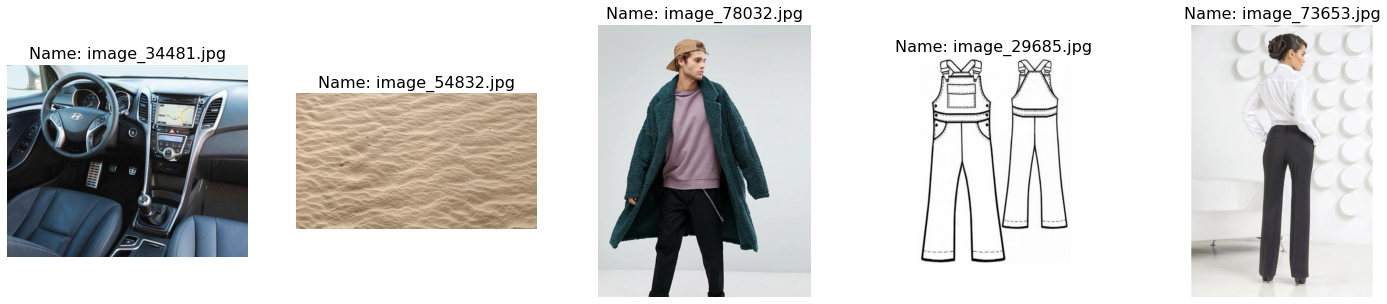

In [87]:
show_images(images.values, 0, 5, random=True)

## Play with model

In [ ]:
# model_i2t

In [ ]:
get_num_of_params(model_i2t)

64327632

In [ ]:
text_encoder = model_i2t.encoders.text.encoder
get_num_of_params(text_encoder)

40243600

In [ ]:
model_i2t.encoders.image

VariationalModalityEncoder(
  (encoder): ImageModel(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
modality = 'image'

In [ ]:
output = model_i2t.encoders.image(sample_batch[modality])

In [ ]:
# output

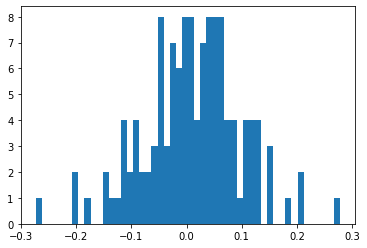

In [ ]:
plt.hist(output[0][0].detach().numpy(), bins=50)
plt.show()

In [ ]:
# output[0]

## step model

In [140]:
loss = model_i2t.training_step(sample_batch, 0)
loss

{'loss': tensor(1.7115, grad_fn=<DivBackward0>)}

In [ ]:
loss = model_i2t.training_step(sample_batch, 0)
loss

tensor([1, 3, 2, 0])
{'nce_i2t': tensor(7.6112, grad_fn=<NllLossBackward>), 'nce_t2i': tensor(5.7763, grad_fn=<NllLossBackward>), 'nce': tensor(6.6937, grad_fn=<DivBackward0>)}


{'loss': tensor(6.6937, grad_fn=<DivBackward0>)}

## forward

In [ ]:
output = model_i2t(sample_batch)

In [ ]:
output['text'].shape, output['image'].shape

(torch.Size([4, 128]), torch.Size([4, 128]))

In [ ]:
image_features = output['image']
text_features = output['text']

In [ ]:
image_features.shape

torch.Size([4, 128])

In [ ]:
logits = model_i2t.gather_logits(output)
logits.shape

torch.Size([4, 4])

In [ ]:
logits

tensor([[-0.1274, -0.0963, -0.0213, -0.0068],
        [-0.1675, -0.2100, -0.0595, -0.1726],
        [-0.1827, -0.1601, -0.0830, -0.1931],
        [-0.1143, -0.1799, -0.0448, -0.0756]], grad_fn=<MmBackward>)

In [ ]:
num_samples = logits.size()[0]
classes = torch.tensor(np.random.choice(num_samples,num_samples, replace=False))
classes

tensor([2, 1, 3, 0])

In [ ]:
# logits[classes][:,classes]

In [ ]:
logits_2 = image_features[classes] @ text_features.T
logits_2

tensor([[-0.1827, -0.1601, -0.0830, -0.1931],
        [-0.1675, -0.2100, -0.0595, -0.1726],
        [-0.1143, -0.1799, -0.0448, -0.0756],
        [-0.1274, -0.0963, -0.0213, -0.0068]], grad_fn=<MmBackward>)

In [ ]:
logits_2.T

tensor([[-0.1827, -0.1675, -0.1143, -0.1274],
        [-0.1601, -0.2100, -0.1799, -0.0963],
        [-0.0830, -0.0595, -0.0448, -0.0213],
        [-0.1931, -0.1726, -0.0756, -0.0068]], grad_fn=<PermuteBackward>)

# Run

In [ ]:
!pwd

/Users/michaelka/Developer/ml/projects/ycup21/main


In [ ]:
!python main.py path=local mode=debug train.trainer_params.gpus=0 +experiment=bert

train:
  batch_size_train: ${mode.batch_size_train}
  batch_size_val: ${mode.batch_size_val}
  trainer_params:
    gpus: 0
    deterministic: true
    num_sanity_val_steps: 0
    checkpoint_callback: false
    max_epochs: ${mode.max_epochs}
    log_every_n_steps: ${mode.log_every_n_steps}
data:
  dataloader_workers: ${path.dataloader_workers}
  collate_fn: false
  split_ratio: 0.9
  metadata:
    metadata_directory: ${path.metadata_directory}
    dataset_size: ${mode.dataset_size}
  train:
    images_directory: ${path.images_directory}
    randomize: true
  val:
    images_directory: ${path.images_directory}
    randomize: false
tokenizer: bert
model:
  text:
    _target_: model.ModalityEncoder
    output_dim: ${model.joint_dim}
    normalize: true
    encoder:
      _target_: model.BERTModel
      model_name: xlm-roberta-base
  joint_dim: 128
  image:
    _target_: model.ModalityEncoder
    output_dim: ${model.joint_dim}
    normalize: true
    encoder:
      _target_: model.ImageMode